
## Evaluating the performance of a hybrid power plant with P2X using HyDesign

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Plant design:**

1. Number of wind turbines in the wind plant [-] (`Nwt`)
2. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

3. Solar plant power capacity [MW] (`solar_MW`)

**Battery Storage design:**

4. Battery power [MW] (`b_P`)
5. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
6. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.

**Electrolyzer design:**

5. Electrolyzer capacity [MW] (`ptg_MW`)

##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# # Install hydesign if needed
# import importlib
# if not importlib.util.find_spec("hydesign"):
#     !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [2]:
 
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.hpp_assembly_P2X_v1 import hpp_model_P2X
from hydesign.examples import examples_filepath

##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [3]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0)
examples_sites

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/input_ts_Indian_site_bad_solar_bad_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W


##
**Select a site to run**

In [4]:
name = 'Denmark_good_wind_H2demand'

ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

In [5]:
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]

input_ts = pd.read_csv(input_ts_fn, index_col=0, parse_dates=True)

required_cols = [col for col in input_ts.columns if 'WD' not in col]
input_ts = input_ts.loc[:,required_cols]
input_ts

,WS_1,WS_50,WS_100,WS_150,WS_200,temp_air_1,ghi,dni,dhi,Price,H2_demand,Unnamed: 17,Unnamed: 18
2012-01-01 00:00:00,3.288440,8.417390,10.213819,11.600266,13.410397,276.767325,0.035121,0.0,0.035121,32.158,50,NaN,1885.685496
2012-01-01 01:00:00,3.274595,8.398900,10.193205,11.776955,13.505000,277.374423,0.017560,0.0,0.017560,32.158,50,NaN,1885.685496
2012-01-01 02:00:00,3.562195,8.909059,10.765491,12.512967,14.097999,278.015879,0.000000,0.0,0.000000,32.158,50,NaN,1885.685496
2012-01-01 03:00:00,3.994770,9.681503,11.634468,13.791528,15.302164,278.655888,0.000000,0.0,0.000000,32.158,50,NaN,1885.685496
2012-01-01 04:00:00,4.280727,10.094911,12.071632,14.358765,15.676826,279.290819,0.000000,0.0,0.000000,32.158,50,NaN,1885.685496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,6.982550,15.994200,19.028254,21.861165,23.342218,280.869008,0.000000,0.0,0.000000,35.446,50,NaN,1885.685496
2012-12-31 20:00:00,6.701203,15.384391,18.312855,21.021135,22.469301,280.877234,0.000000,0.0,0.000000,33.565,50,NaN,1885.685496
2012-12-31 21:00:00,6.250792,14.444226,17.213032,19.796159,21.174110,280.891512,0.000000,0.0,0.000000,32.709,50,NaN,1885.685496
2012-12-31 22:00:00,5.121517,11.980019,14.307815,16.421864,17.590641,280.635464,0.000000,0.0,0.000000,31.392,50,NaN,1885.685496


In [6]:
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]

with open(sim_pars_fn) as file:
    sim_pars = yaml.load(file, Loader=yaml.FullLoader)

print(sim_pars_fn)    
sim_pars

/home/gupta/hydesign/hydesign/examples/Europe/hpp_pars.yml


{'G_MW': 300,
 'year': '2012',
 'N_life': 25,
 'wind_turbine_cost': 640000,
 'wind_civil_works_cost': 260000,
 'wind_fixed_onm_cost': 12600,
 'wind_variable_onm_cost': 1.35,
 'wpp_efficiency': 1.0,
 'd_ref': 145,
 'hh_ref': 100,
 'p_rated_ref': 5.0,
 'solar_PV_cost': 110000,
 'solar_hardware_installation_cost': 100000,
 'solar_inverter_cost': 20000,
 'solar_fixed_onm_cost': 4500,
 'pv_deg_per_year': 0.005,
 'land_use_per_solar_MW': 0.01226,
 'tracking': 'No',
 'battery_energy_cost': 45000,
 'battery_power_cost': 16000,
 'battery_BOP_installation_commissioning_cost': 18000,
 'battery_control_system_cost': 4500,
 'battery_energy_onm_cost': 0,
 'battery_depth_of_discharge': 0.9,
 'battery_charge_efficiency': 0.98,
 'battery_price_reduction_per_year': 0.1,
 'peak_hr_quantile': 0.9,
 'n_steps_in_LoH': 20,
 'min_LoH': 0.7,
 'n_full_power_hours_expected_per_day_at_peak_price': 0,
 'price_H2': 5,
 'storage_eff': 1,
 'ptg_deg': 0.99,
 'hhv': 39.3,
 'water_consumption': 9.4,
 'electrolyzer_capex

## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [7]:
hpp = hpp_model_P2X(
        latitude,
        longitude,
        altitude,
        num_batteries = 1,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
)

longitude = 8.594398
latitude = 56.227322
altitude = 85.0


##
### Evaluating the HPP model

In [8]:
start = time.time()

clearance = 10
sp = 360
p_rated = 4        
Nwt = 90
wind_MW_per_km2 = 5
solar_MW = 80
surface_tilt = 50
surface_azimuth = 210
DC_AC_ratio = 1
b_P = 10
b_E_h  = 10
cost_of_batt_degr = 2
ptg_MW = 120

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, solar_MW, \
surface_tilt, surface_azimuth, DC_AC_ratio, b_P, b_E_h , cost_of_batt_degr, ptg_MW]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
clearance [m]: 10.000
sp [m2/W]: 360.000
p_rated [MW]: 4.000
Nwt: 90.000
wind_MW_per_km2 [MW/km2]: 5.000
solar_MW [MW]: 80.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 210.000
DC_AC_ratio: 1.000
b_P [MW]: 10.000
b_E_h [h]: 10.000
cost_of_battery_P_fluct_in_peak_price_ratio: 2.000
ptg_MW [MW]: 120.000


NPV_over_CAPEX: 0.122
NPV [MEuro]: 50.356
IRR: 0.069
LCOE [Euro/MWh]: 28.102
CAPEX [MEuro]: 411.529
OPEX [MEuro]: 9.033
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 1425.607
GUF: 0.542
annual H2 [kg]: 346520.412
grid [MW]: 300.000
wind [MW]: 360.000
solar [MW]: 80.000
PtG [MW]: 120.000
Battery Energy [MWh]: 100.000
Battery Power [MW]: 10.000
Total curtailment [GWh]: 2318.492
Awpp [km2]: 72.000
Rotor diam [m]: 118.942
Hub height [m]: 69.471
Number_of_batteries: 1.000

exec. time [min]: 0.4062871297200521


##
### Plot the HPP operation

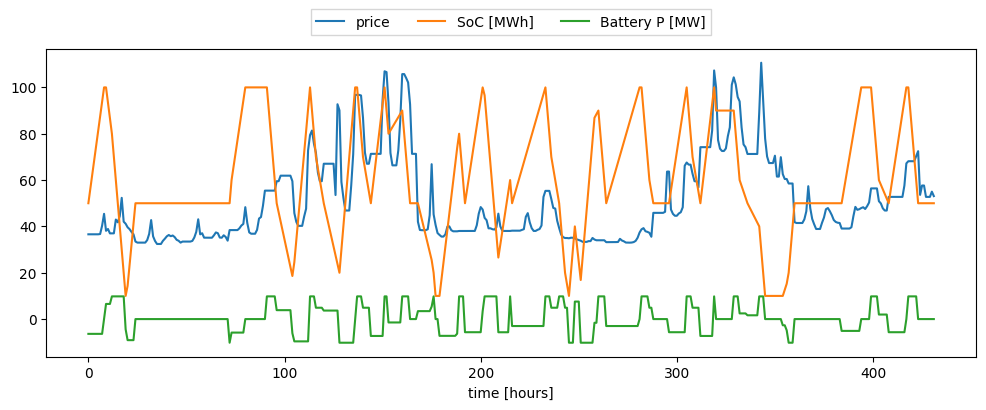

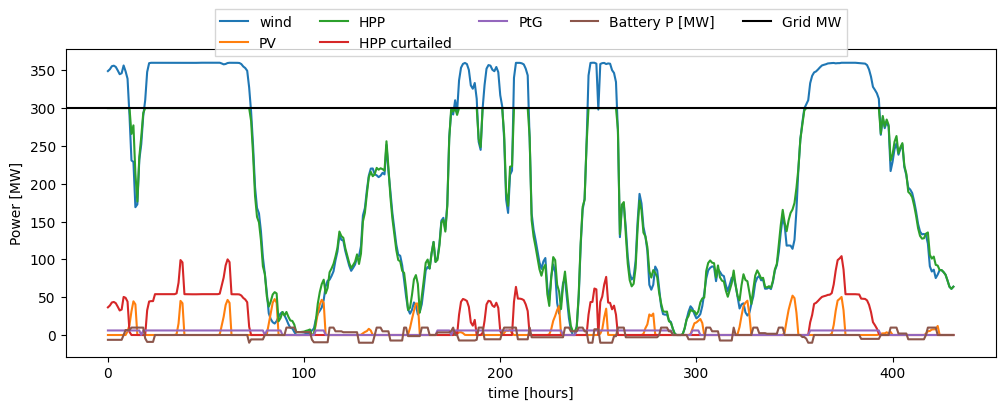

In [9]:
b_E_SOC_t = hpp.prob.get_val('ems_P2X.b_E_SOC_t')
b_t = hpp.prob.get_val('ems_P2X.b_t')
price_t = hpp.prob.get_val('ems_P2X.price_t')

wind_t = hpp.prob.get_val('ems_P2X.wind_t')
solar_t = hpp.prob.get_val('ems_P2X.solar_t')
hpp_t = hpp.prob.get_val('ems_P2X.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems_P2X.hpp_curt_t')
P_ptg_t = hpp.prob.get_val('ems_P2X.P_ptg_t')
grid_MW = hpp.prob.get_val('ems_P2X.G_MW')
m_H2_t = hpp.prob.get_val('ems_P2X.m_H2_t')

start_day = 10*24
n_days_plot = 28
plt.figure(figsize=[12,4])
plt.plot(price_t[start_day:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[start_day:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[start_day:24*n_days_plot], label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(wind_t[start_day:24*n_days_plot], label='wind')
plt.plot(solar_t[start_day:24*n_days_plot], label='PV')
plt.plot(hpp_t[start_day:24*n_days_plot], label='HPP')
plt.plot(hpp_curt_t[start_day:24*n_days_plot], label='HPP curtailed')
plt.plot(P_ptg_t[start_day:24*n_days_plot], label='PtG')
plt.plot(b_t[start_day:24*n_days_plot], label='Battery P [MW]')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)
#plt.savefig('plot_EMS_p2x_80.png')

In [10]:

# data = {'Electricity Price':price_t, 'Wind Power': wind_t,'Solar Power': solar_t,'HPP Power': hpp_t[:8784],'Curtailed Power': hpp_curt_t[:8784] ,'Power PtG': P_ptg_t[:8784],'Battery SOC': b_E_SOC_t[:8784],'Battery Power': b_t[:8784], 'H2 produced': m_H2_t[:8784]}
# df = pd.DataFrame(data)
# df.to_csv('EMS_out.csv')

In [11]:
# plt.figure(figsize=[12,4])
# plt.plot(price_t[start_day:24*n_days_plot], label = 'Electricity prices (1.2 times) (Euro/MWh)')
# plt.xlabel('time [hours]')
# plt.ylabel('Electricity prices (Euro/MWh)')
# plt.legend(loc='upper left', bbox_to_anchor=(0.5, 1.15),
#            ncol=3, fancybox=0, shadow=0)
# plt.savefig('Denmark_good_wind_electricity_prices.png')

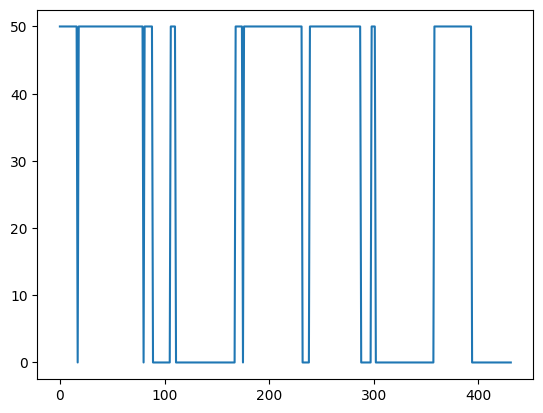

In [12]:
plt.plot(m_H2_t[start_day:24*n_days_plot])
m_H2_demand_t = hpp.prob.get_val('ems_P2X.m_H2_demand_t_ext')

In [13]:
print(m_H2_demand_t)

[50. 50. 50. ... 50. 50. 50.]
